In [79]:
import heapq
import itertools
import random
import matplotlib.pyplot as plt
import noise
import numpy as np
from PIL import Image
from cv2 import GaussianBlur, circle, polylines
from tqdm import trange, tqdm

SIZE_N = 800
NODE_N = 64
np.random.seed(42)
plt.figure(figsize=(17, 8))
node_points = np.random.rand(NODE_N, 2)*10

<Figure size 1700x800 with 0 Axes>

# Solving TSP problem using GA for the ring

In [78]:
def generate_distance_matrix(node_points):
    matrix = np.zeros((NODE_N, NODE_N))
    for i in range(NODE_N):
        for j in range(i+1, NODE_N):
            distance = np.linalg.norm(node_points[i] - node_points[j])
            matrix[i, j] = distance
            matrix[j, i] = distance
    return matrix

def prim_mst(distance_matrix):
    visited = [False] * NODE_N
    min_edge = [(0, 0)]  # (邊的權重，目標節點)
    total_weight = 0
    
    while len(min_edge) > 0:
        weight, node = heapq.heappop(min_edge)
        if visited[node]:
            continue
        visited[node] = True
        total_weight += weight
        
        for neighbor in range(NODE_N):
            if not visited[neighbor]:
                heapq.heappush(min_edge, (distance_matrix[node][neighbor], neighbor))
    
    return total_weight

# 計算 TSP 問題的下界
def tsp_lower_bound(distance_matrix):
    mst_weight = prim_mst(distance_matrix)  # 計算最小生成樹的權重

    # 找出與城市0相關的兩個最小邊，將其加到最小生成樹的權重中
    first_min_edge = float('inf')
    second_min_edge = float('inf')
    
    for i in range(1, NODE_N):
        if distance_matrix[0][i] < first_min_edge:
            second_min_edge = first_min_edge
            first_min_edge = distance_matrix[0][i]
        elif distance_matrix[0][i] < second_min_edge:
            second_min_edge = distance_matrix[0][i]
    
    lower_bound = mst_weight + first_min_edge + second_min_edge
    return lower_bound

In [ ]:
# 計算一條路徑的總距離
def calculate_total_distance(route, distance_matrix) -> float:
    total_distance = 0
    for i in range(len(route) - 1):
        total_distance += distance_matrix[route[i], route[i+1]]
    total_distance += distance_matrix[route[-1], route[0]]  # 回到起點的距離
    return total_distance

# 初始化種群，生成多條隨機路徑
def init_population(pop_size):
    population = [np.random.permutation(NODE_N) for _ in range(pop_size)]
    return population

# tournament selection
def tournament_selection(population: list[np.ndarray], distance_matrix, keepPercent=0.1, tournament_size=5) -> list[np.ndarray]:
    selected = []
    num_to_select = int(keepPercent * len(population))
    
    for _ in range(num_to_select):
        tournament = random.sample(population, tournament_size)
        tournament_fitness = [calculate_total_distance(route, distance_matrix) for route in tournament]
        winner = tournament[np.argmin(tournament_fitness)]
        selected.append(winner)
    
    return selected

# Edge Recombination crossover
def edge_recombination(parent1, parent2):
    # 建立邊列表
    edges = {i: set() for i in parent1}
    for i in range(len(parent1)):
        left_p1, right_p1 = parent1[i-1], parent1[(i+1) % len(parent1)]
        left_p2, right_p2 = parent2[i-1], parent2[(i+1) % len(parent2)]
        edges[parent1[i]].update([left_p1, right_p1])
        edges[parent2[i]].update([left_p2, right_p2])

    # 隨機選擇一個起始點
    current = random.choice(parent1)
    child = [current]
    
    # 構建子代
    while len(child) < len(parent1):
        for edge in edges.values():
            edge.discard(current)  # 移除已經選擇的點

        if edges[current]:
            current = min(edges[current], key=lambda x: len(edges[x]))  # 選擇最少鄰邊的點
        else:
            current = random.choice([city for city in parent1 if city not in child])
        child.append(current)
    
    return child

# Insert Mutation
def insert_mutate(route, mutation_rate=0.01):
    if random.random() < mutation_rate:
        # 隨機選擇兩個位置
        i, j = random.sample(range(len(route)), 2)
        # 插入操作
        gene = route.pop(i)
        route.insert(j, gene)
    return route

In [ ]:
# 3-opt 優化
def three_opt(route, distance_matrix):
    route = route
    n = len(route)
    improved = True
    best_dist = float('inf')
    while improved:
        improved = False
        for (i, j, k) in tqdm(itertools.combinations(range(n), 3)):
            # 將三條邊進行3-opt交換
            new_route = route[:i] + route[i:j][::-1] + route[j:k][::-1] + route[k:]
            new_dist = calculate_total_distance(new_route, distance_matrix)
            if new_dist < best_dist:
                best_dist = new_dist
                route = new_route
                improved = True
    return route

In [ ]:
def genetic_algorithm(distance_matrix, pop_size=200, generations=500, mutation_rate=0.5, keepPercent=0.25):
    population = init_population(pop_size)
    # print(population.shape)
    best_route = np.arange(NODE_N, dtype=int)
    best_distance = float('inf')
    best_history = []
    ttt = trange(generations)
    for generation in ttt:
        new_population = []
        selected = tournament_selection(population, distance_matrix, keepPercent)
        for i in range(pop_size - len(selected)):
            parent1, parent2 = np.random.choice(len(selected), size=2, replace=False)
            child1 = edge_recombination(selected[parent1], selected[parent2])
            # varible mutation_rate
            child1 = insert_mutate(child1, (1-i/pop_size) * mutation_rate)
            new_population.append(child1)
        population = selected + new_population
        
        # 找到當前代中的最佳路徑
        routeDistances = [calculate_total_distance(route, distance_matrix) for route in population]
        best_idx = np.argmin(routeDistances)
        current_best_route = population[best_idx]
        current_best_distance = min(routeDistances)
        
        if current_best_distance < best_distance:
            best_distance = current_best_distance
            best_route = current_best_route

        best_history.append(best_distance)
        ttt.set_description(f"Best Dist: {best_distance:9.3f}")
            
    # 3-opt優化
    current_best_route = three_opt(current_best_route, distance_matrix)
    current_best_distance = calculate_total_distance(current_best_route, distance_matrix)
    if current_best_distance < best_distance:
        best_distance = current_best_distance
        best_route = current_best_route
        best_history.append(best_distance)
        # plot_route(best_route, text, best_history)
    return best_route, best_distance

# 測試
distance_matrix = generate_distance_matrix()
tspLBound = tsp_lower_bound(distance_matrix)
best_route, best_distance = genetic_algorithm(distance_matrix, tspLBound)
print("\nLower bound:", tspLBound)
print("Optimal distance:", best_distance)

# perlin noise

In [2]:
def rgb_norm(world):
    world_min = np.min(world)
    world_max = np.max(world)
    norm = lambda x: (x-world_min/(world_max - world_min))*255
    return np.vectorize(norm)

def prep_world(world):
    norm = rgb_norm(world)
    world = norm(world)
    return world

-0.4155537486076355 0.4576026499271393


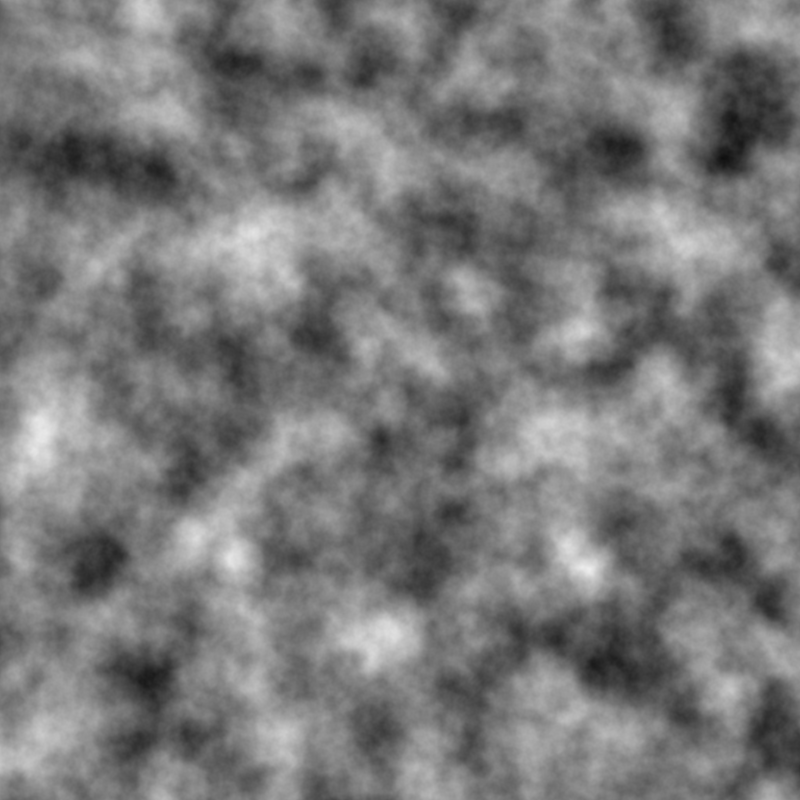

In [ ]:
shape = (SIZE, SIZE)
scale = 100
octaves = 6
persistence = 0.5
lacunarity = 2
seed = np.random.randint(0, 100000)
seed = 42

world = np.zeros(shape)
for i in range(shape[0]):
    for j in range(shape[1]):
        world[i][j] = noise.pnoise2(i/scale, 
                                    j/scale, 
                                    octaves=octaves, 
                                    persistence=persistence, 
                                    lacunarity=lacunarity, 
                                    repeatx=1024, 
                                    repeaty=1024, 
                                    base=seed)

# Image.fromarray(prep_world(world)).show()
print(np.min(world), np.max(world))
# world = prep_world(world)
# print(np.min(world), np.max(world))
result = Image.fromarray(prep_world(world)).convert('L')
display(result)

# adding color

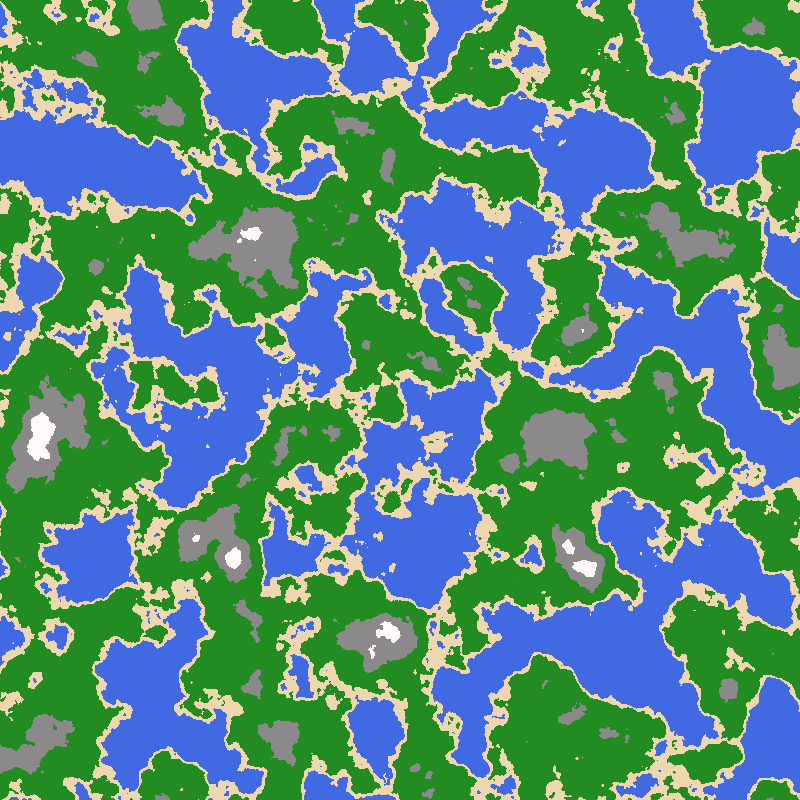

In [18]:
blue = [65, 105, 225]
green = [34, 139, 34]
beach = [238, 214, 175]
snow = [255, 250, 250]
mountain = [139, 137, 137]

def add_color(world):
    color_world = np.zeros(world.shape+(3,))
    for i in range(shape[0]):
        for j in range(shape[1]):
            if world[i][j] < -0.05:
                color_world[i][j] = blue
            elif world[i][j] < 0:
                color_world[i][j] = beach
            elif world[i][j] < .20:
                color_world[i][j] = green
            elif world[i][j] < 0.35:
                color_world[i][j] = mountain
            elif world[i][j] < 1.0:
                color_world[i][j] = snow

    return color_world

color_world = add_color(world).astype(np.uint8)
#Image.fromarray(color_world,'RGB').show()
display(Image.fromarray(color_world,'RGB'))

# Create mask

1.0 0.0


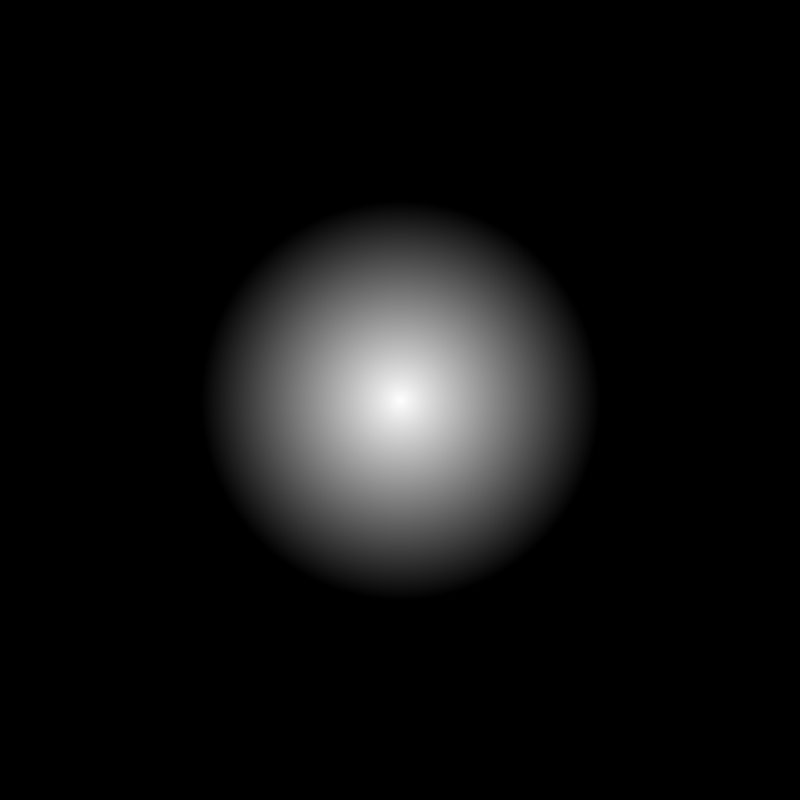

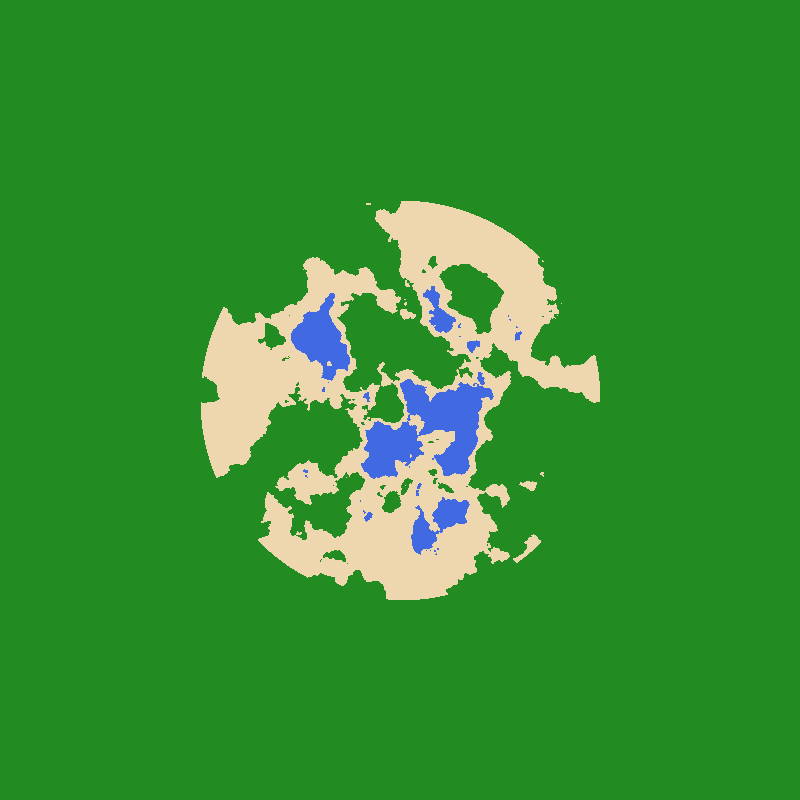

In [19]:
def center_mask(size, radius):
    mask = np.zeros(size)
    center = (size[0]//2, size[1]//2)
    for i in range(size[0]):
        for j in range(size[1]):
            if (a := (i-center[0])**2 + (j-center[1])**2) < radius**2:
                mask[i][j] = 1-np.sqrt(a)/radius
                
    return mask

mask = center_mask(shape, 200)
print(np.max(mask), np.min(mask))
display(Image.fromarray(mask*255).convert('L'))
masked_world = world*mask
color_world = add_color(masked_world).astype(np.uint8)
display(Image.fromarray(color_world,'RGB'))

[[200 200]
 [400 200]
 [600 200]
 [600 400]
 [600 600]
 [400 600]
 [200 600]
 [300 500]
 [400 400]
 [300 300]] int32 (10, 2)


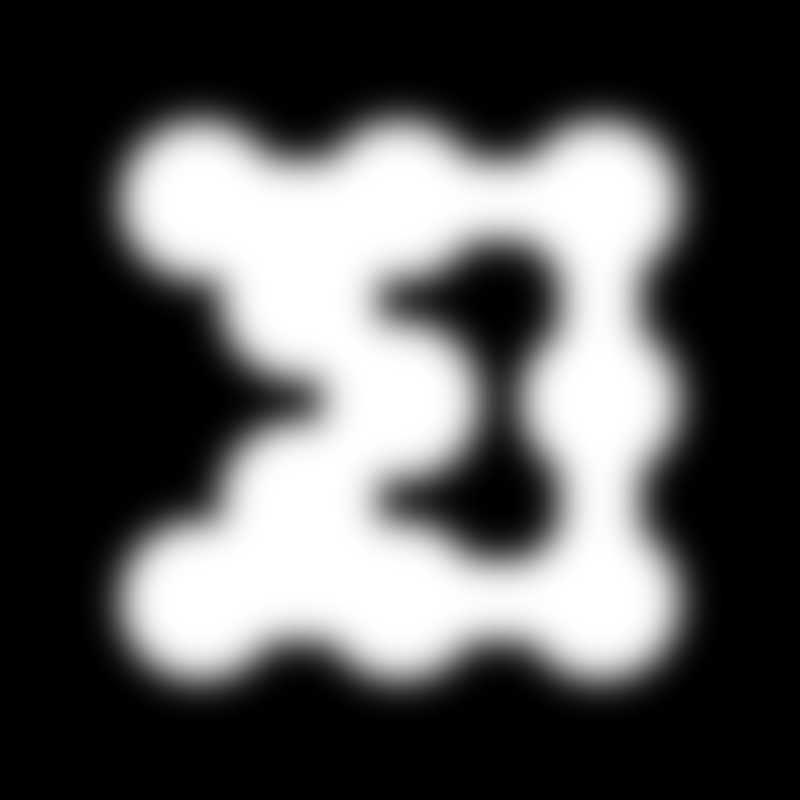

In [76]:
def generate_ring_mask(nodes, thickness=80, blur_kernel_size=15, blur_repeats=1):
    """
    Generates a ring-like alpha mask for a given path with deviation in width using 1D Perlin noise.
    
    Parameters:
        nodes (list of tuples): 2D coordinates of the path nodes (e.g., [(x1, y1), (x2, y2), ...]).
        thickness (int): Base thickness of the ring.
        blur_kernel_size (int): Size of the Gaussian blur kernel for smoothing the edges.
        blur_repeats (int): Number of times to apply the Gaussian blur.
        scale (int): Scale of the Perlin noise.
        octaves (int): Number of octaves for the Perlin noise.
        persistence (float): Persistence of the Perlin noise.
        lacunarity (float): Lacunarity of the Perlin noise.
        seed (int): Seed for the Perlin noise.
        
    Returns:
        np.ndarray: Alpha mask as a 2D NumPy array.
    """
    # Create an empty black canvas
    mask = np.zeros((SIZE_N, SIZE_N), dtype=np.uint8)
    
    # Convert nodes to integer coordinates
    length = len(nodes)
    int_nodes = np.array(nodes, dtype=np.int32)
    sub_nodes = np.zeros((length*2, 2), dtype=np.int32)
    
    for i in range(length):
        start = int_nodes[i]
        end = int_nodes[(i + 1) % length]
        sub_nodes[i*2] = start
        sub_nodes[i*2+1] = (start + end) // 2
    
    print(sub_nodes, sub_nodes.dtype, sub_nodes.shape)
    polylines(mask, [sub_nodes], isClosed=True, color=255, thickness=thickness)
    
    for sn in sub_nodes:
        circle(mask, sn, thickness, 255, -1)
    # Apply Gaussian blur to soften edges
    blurred_mask = mask.copy()
    for _ in range(blur_repeats):
        blurred_mask = GaussianBlur(blurred_mask, (blur_kernel_size, blur_kernel_size), 0)
    
    return blurred_mask

nodes = [(200, 200), (600, 200), (600, 600), (200, 600), (400, 400)]
mask = generate_ring_mask(nodes, blur_repeats=50)
display(Image.fromarray(mask).convert('L'))

[[200 200]
 [400 200]
 [600 200]
 [600 400]
 [600 600]
 [400 600]
 [200 600]
 [300 500]
 [400 400]
 [300 300]] int32 (10, 2)


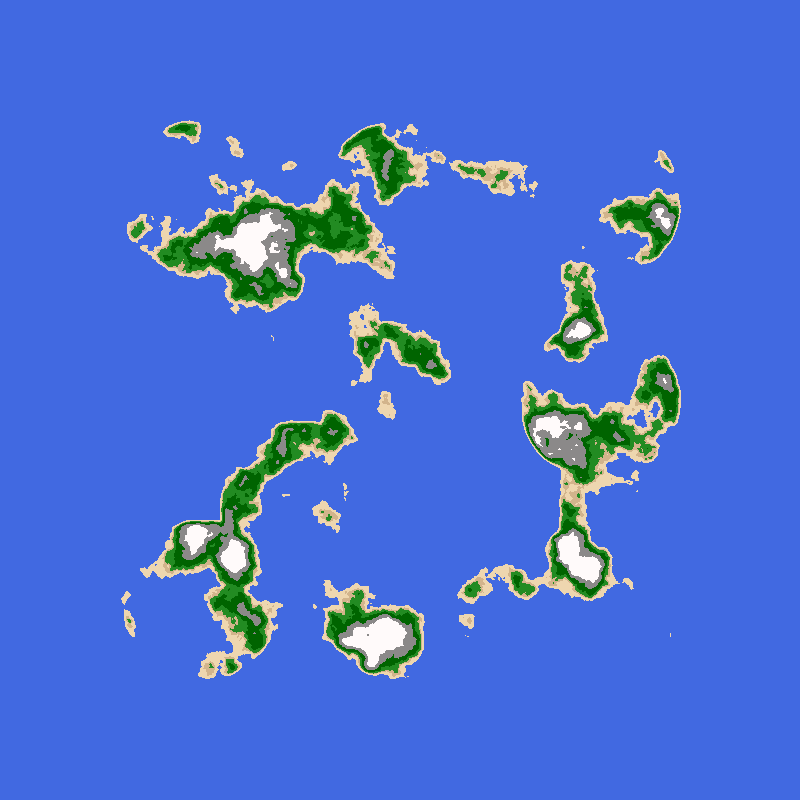

In [77]:
lightblue = [0,191,255]
blue = [65,105,225]
green = [34,139,34]
darkgreen = [0,100,0]
sandy = [210,180,140]
beach = [238, 214, 175]
snow = [255, 250, 250]
mountain = [139, 137, 137]

threshold = 40

def add_color2(world):
    color_world = np.zeros(world.shape + (3,))
    for i in range(shape[0]):
        for j in range(shape[1]):
            if world[i][j] < threshold + 90:
                color_world[i][j] = blue
            elif world[i][j] < threshold + 100:
                color_world[i][j] = beach
            elif world[i][j] < threshold + 105:
                color_world[i][j] = sandy
            elif world[i][j] < threshold + 115:
                color_world[i][j] = green
            elif world[i][j] < threshold + 130:
                color_world[i][j] = darkgreen
            elif world[i][j] < threshold + 145:
                color_world[i][j] = mountain
            else:
                color_world[i][j] = snow

    return color_world

mask = generate_ring_mask(nodes) / 255
masked_world = world*mask
island_world_grad = add_color2(prep_world(masked_world)).astype(np.uint8)
display(Image.fromarray(island_world_grad,'RGB'))